In [8]:
pip install pandas numpy scikit-learn xgboost

You should consider upgrading via the '/Users/elisabethlelesle/Documents/BACHELOR/S5/Data Mining/Data_Mining/HW4_Data_Mining/Assignment4/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report



In [12]:
# Load the dataset
data = pd.read_csv("bank.csv", delimiter=";")
print(data.head())

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  


In [13]:
# Remove Job, Month, Day columns and define 'y' as the label
data = data.drop(columns=["job", "month", "day"])
X = data.drop(columns=["y"])
y = data["y"].apply(lambda x: 1 if x == "yes" else 0)  # Encode 'y' as binary

print(data.head())

   age  marital  education default  balance housing loan   contact  duration  \
0   30  married    primary      no     1787      no   no  cellular        79   
1   33  married  secondary      no     4789     yes  yes  cellular       220   
2   35   single   tertiary      no     1350     yes   no  cellular       185   
3   30  married   tertiary      no     1476     yes  yes   unknown       199   
4   59  married  secondary      no        0     yes   no   unknown       226   

   campaign  pdays  previous poutcome   y  
0         1     -1         0  unknown  no  
1         1    339         4  failure  no  
2         1    330         1  failure  no  
3         4     -1         0  unknown  no  
4         1     -1         0  unknown  no  


In [29]:
from sklearn.preprocessing import OneHotEncoder

# Encode categorical variables using one-hot encoding
categorical_columns = X.select_dtypes(include=["object"]).columns  # Identify categorical columns
encoder = OneHotEncoder(sparse_output=False, drop="first")  # Avoid collinearity by dropping the first category
encoded_features = pd.DataFrame(
    encoder.fit_transform(X[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Replace categorical columns with encoded ones
X = X.drop(columns=categorical_columns).reset_index(drop=True)
X = pd.concat([X, encoded_features], axis=1)

# Ensure data types are consistent
X = X.astype(float)

# The rest of the process remains unchanged
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Decision Tree (CART)
cart = DecisionTreeClassifier(random_state=42)
cart.fit(X_train, y_train)

# Identify important predictors
feature_importances = pd.Series(cart.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances from Decision Tree (CART):")
print(feature_importances)


Feature Importances from Decision Tree (CART):
duration               0.350536
balance                0.149795
age                    0.132346
poutcome_success       0.086168
campaign               0.057825
pdays                  0.056797
previous               0.029426
education_tertiary     0.028517
housing_yes            0.017522
education_secondary    0.015802
marital_married        0.015505
contact_unknown        0.014021
contact_telephone      0.012707
education_unknown      0.011405
marital_single         0.007237
poutcome_unknown       0.004602
loan_yes               0.003695
poutcome_other         0.003360
default_yes            0.002735
dtype: float64


In [35]:
# Part (b): Derive the response for a new sample
# Compute median for numeric features and mode for one-hot encoded categorical features
numeric_median = X_train.median().to_dict()  # Median for numeric features

# Calculate the mode for one-hot encoded categorical features
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
categorical_mode = pd.DataFrame(X_train[encoded_feature_names]).mode().iloc[0]
categorical_mode_dict = dict(zip(encoded_feature_names, categorical_mode))

# Combine median and mode into a single sample
new_sample = numeric_median.copy()
new_sample.update(categorical_mode_dict)

# Convert to DataFrame
new_sample_df = pd.DataFrame([new_sample], columns=X_train.columns)

# Predict response
response = cart.predict(new_sample_df)
response_label = "yes" if response[0] == 1 else "no"
print(f"\nPredicted Response for New Sample: {response_label}")




Predicted Response for New Sample: no


In [36]:
# Part (c): Random Forest and Gradient Boosting with Partial Predictors

# Step 1: Select important features from CART
important_features = feature_importances[feature_importances > 0].index
X_train_partial = X_train[important_features]
X_test_partial = X_test[important_features]

# Step 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_partial, y_train)
rf_pred = rf.predict(X_test_partial)

# Step 3: Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_partial, y_train)
gb_pred = gb.predict(X_test_partial)

In [37]:
# Step 4: Evaluate performance
print("\nPerformance Comparison:")

# Random Forest Metrics
print("\nRandom Forest:")
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_class_report = classification_report(
    y_test, rf_pred, target_names=["y-no", "y-yes"], output_dict=True
)
print(f"Overall Accuracy: {rf_accuracy:.4f}")
print(f"Accuracy for y-no: {rf_class_report['y-no']['precision']:.4f}")
print(f"Accuracy for y-yes: {rf_class_report['y-yes']['precision']:.4f}")

# Gradient Boosting Metrics
print("\nGradient Boosting:")
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_class_report = classification_report(
    y_test, gb_pred, target_names=["y-no", "y-yes"], output_dict=True
)
print(f"Overall Accuracy: {gb_accuracy:.4f}")
print(f"Accuracy for y-no: {gb_class_report['y-no']['precision']:.4f}")
print(f"Accuracy for y-yes: {gb_class_report['y-yes']['precision']:.4f}")


Performance Comparison:

Random Forest:
Overall Accuracy: 0.8931
Accuracy for y-no: 0.9121
Accuracy for y-yes: 0.5493

Gradient Boosting:
Overall Accuracy: 0.8946
Accuracy for y-no: 0.9168
Accuracy for y-yes: 0.5542


In [39]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 673.7 kB/s eta 0:00:0000:0100:01
  Using cached importlib_resources-6.4.5-py3-none-any.whl (36 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 484.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 KB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 KB 788.3 kB/s eta 0:00:00 0:00:01
  Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
You should consider upgrading via the '/Users/elisabethlelesle/Documents/BACHELOR/S5/Data Mining/Data_Mining/HW4_Data_Mining/Assignment4/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay
)
import matplotlib.pyplot as plt

In [ ]:
file_path = "churn.txt" 
data = pd.read_csv(file_path, delimiter=',') 

# Remove rows where CHURNED is "InVol"
data = data[data["CHURNED"] != "InVol"].reset_index(drop=True)

In [43]:
# Encode categorical variables
label_encoders = {}
for col in ["PAY_MTHD", "LocalBillType", "LongDistanceBillType", "SEX", "STATUS", "Car_Owner", "CHURNED"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [45]:
# Split features and target
X = data.drop(columns=["ID", "CHURNED"])
y = data["CHURNED"]  # "Vol" is encoded as 1, "Current" as 0

In [46]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
# Step 4: Train models and select important features
# CART
cart = DecisionTreeClassifier(random_state=42)
cart.fit(X_train, y_train)
cart_importances = pd.Series(cart.feature_importances_, index=X.columns)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# AdaBoost
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train, y_train)
adaboost_importances = pd.Series(adaboost.feature_importances_, index=X.columns)

# Identify common predictors with high importance
common_features = (
    cart_importances[cart_importances > 0]
    .index.intersection(rf_importances[rf_importances > 0].index)
    .intersection(adaboost_importances[adaboost_importances > 0].index)
)
print("Common predictors with high importance:", list(common_features))

Common predictors with high importance: ['LONGDIST', 'International', 'LOCAL', 'AGE', 'SEX', 'Est_Income']


/Users/elisabethlelesle/Documents/BACHELOR/S5/Data Mining/Data_Mining/HW4_Data_Mining/Assignment4/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [48]:
# Step 5: Evaluate models
models = {"CART": cart, "Random Forest": rf, "AdaBoost": adaboost}
metrics = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Classification report
    class_report = classification_report(
        y_test, y_pred, target_names=["Current", "Vol"], output_dict=True
    )
    accuracy = accuracy_score(y_test, y_pred)
    recall = class_report["Vol"]["recall"]
    precision = class_report["Vol"]["precision"]
    f_measure = class_report["Vol"]["f1-score"]
    
    metrics[name] = {
        "Confusion Matrix": conf_matrix,
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F-Measure": f_measure,
    }

# Display metrics
for model_name, values in metrics.items():
    print(f"\n{model_name} Metrics:")
    for key, value in values.items():
        print(f"{key}: {value}")


CART Metrics:
Confusion Matrix: [[212  41]
 [ 43 108]]
Accuracy: 0.7920792079207921
Recall: 0.7152317880794702
Precision: 0.7248322147651006
F-Measure: 0.72

Random Forest Metrics:
Confusion Matrix: [[208  45]
 [ 26 125]]
Accuracy: 0.8242574257425742
Recall: 0.8278145695364238
Precision: 0.7352941176470589
F-Measure: 0.778816199376947

AdaBoost Metrics:
Confusion Matrix: [[208  45]
 [ 38 113]]
Accuracy: 0.7945544554455446
Recall: 0.7483443708609272
Precision: 0.7151898734177216
F-Measure: 0.7313915857605178


CART AUC: 0.7766
Random Forest AUC: 0.8958
AdaBoost AUC: 0.8561


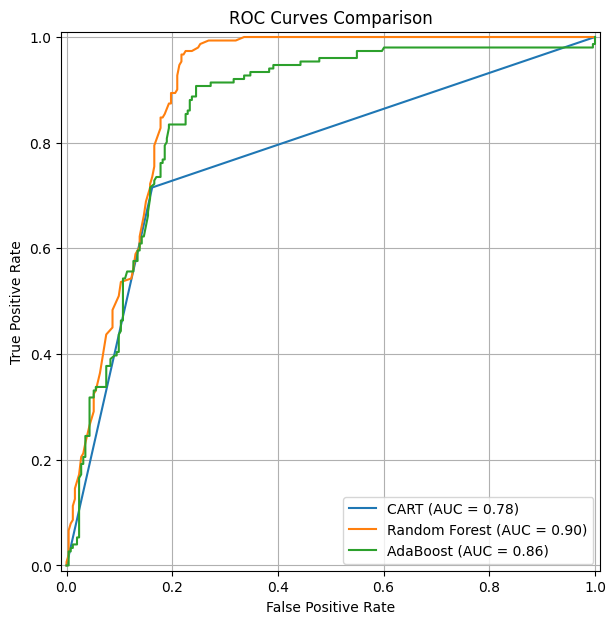

In [49]:
# Step 6: ROC and AUC comparison
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca())
    print(f"{name} AUC: {roc_auc:.4f}")

plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
You should consider upgrading via the '/Users/elisabethlelesle/Documents/BACHELOR/S5/Data Mining/Data_Mining/HW4_Data_Mining/Assignment4/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 1.2 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/Users/elisabethlelesle/Documents/BACHELOR/S5/Data Mining/Data_Mining/HW4_Data_Mining/Assignment4/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
df = pd.read_excel("Asia_Stock.xlsx")

# Check the dataset structure
print(df.head())

        Date        KOREA   TAIWAN   NASDAQ  US10YY          SHI          SHE  \
0 2016-01-04  1918.760010  8114.26  4903.09   2.243  3296.258057  11626.04004   
1 2016-01-05  1930.530029  8075.11  4891.43   2.239  3287.710938  11468.05957   
2 2016-01-06  1925.430054  7990.39  4835.77   2.170  3361.840088  11724.87988   
3 2016-01-07  1904.329956  7852.06  4689.43   2.149  3125.001953  10760.26953   
4 2016-01-08  1917.619995  7893.97  4643.63   2.116  3186.412109  10888.91016   

     SOX       DJI   SP 500        USD         JAPAN         INDIA  Oil.price  \
0  656.3  17148.94  2012.66  98.870003  18450.980469  25623.349609  35.360000   
1  649.5  17158.66  2016.71  99.400002  18374.000000  25580.339844  34.413333   
2  631.2  16906.51  1990.26  99.180000  18191.320312  25406.330078  32.396667   
3  610.3  16514.10  1943.09  98.220001  17767.339844  24851.830078  32.006667   
4  600.5  16346.45  1922.03  98.540001  17697.960938  24934.330078  31.956667   

   Gold.price  
0     1074

In [8]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
# Split dataset into training and testing sets
train = df[df['Date'].dt.year <= 2021]
test = df[df['Date'].dt.year >= 2022]

# Extract predictors and response variable (e.g., 'TAIWAN' as target)
X_train = train.drop(columns=['Date', 'TAIWAN'])  # Drop Date and Target column
y_train = train['TAIWAN']

X_test = test.drop(columns=['Date', 'TAIWAN'])  # Drop Date and Target column
y_test = test['TAIWAN']

In [10]:
# Apply Random Forest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
# Get feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print("Random Forest Feature Importance:")
print(feature_importance)

Random Forest Feature Importance:
INDIA         0.386378
SOX           0.358554
JAPAN         0.142444
SP 500        0.054525
DJI           0.029827
NASDAQ        0.006591
SHE           0.006140
Oil.price     0.004726
USD           0.003125
Gold.price    0.002747
KOREA         0.002497
US10YY        0.001325
SHI           0.001120
dtype: float64


In [12]:
# Build XGBoost model for forecasting
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
# Make predictions with Random Forest and XGBoost
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

In [14]:
# Evaluate models' performance using RMSE, MAE, and MAPE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

rf_mae = mean_absolute_error(y_test, rf_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"Random Forest MAE: {rf_mae:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"Random Forest MAPE: {rf_mape:.4f}")
print(f"XGBoost MAPE: {xgb_mape:.4f}")

Random Forest RMSE: 846.1353
XGBoost RMSE: 1026.4027
Random Forest MAE: 765.5309
XGBoost MAE: 868.0123
Random Forest MAPE: 0.0494
XGBoost MAPE: 0.0558


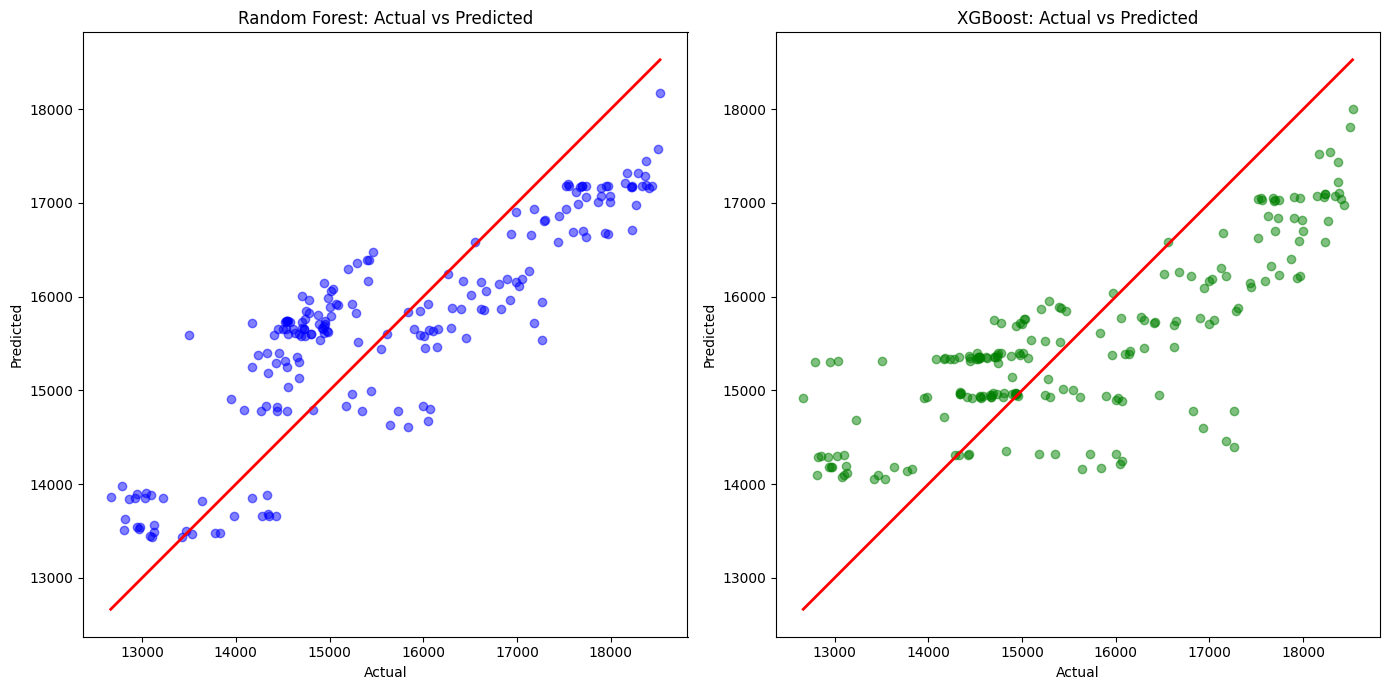

In [15]:
# Plot Actual vs Predicted values for Random Forest and XGBoost
plt.figure(figsize=(14,7))

# Random Forest Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# XGBoost Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_predictions, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

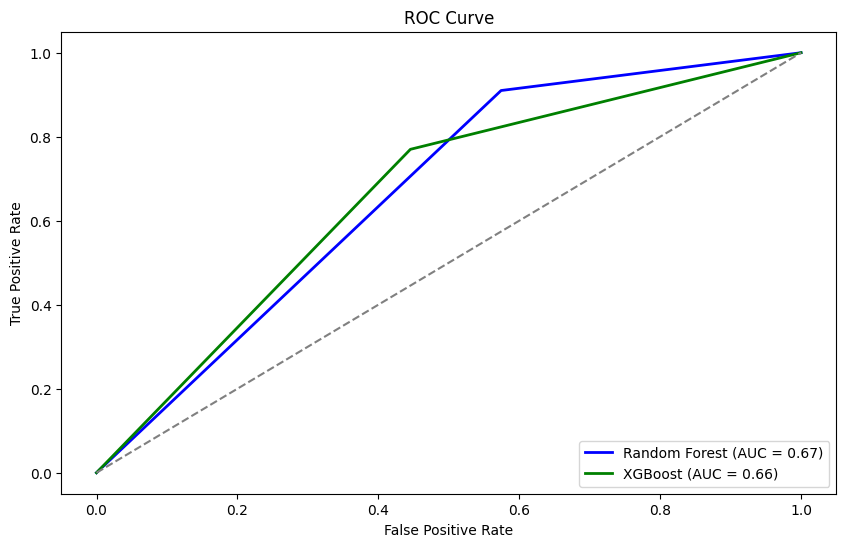

In [16]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc

# Since it's a regression problem, we'll transform predictions into binary classification by setting a threshold (for example, greater than median)
threshold = np.median(y_test)
rf_binary_predictions = (rf_predictions > threshold).astype(int)
xgb_binary_predictions = (xgb_predictions > threshold).astype(int)
y_binary_test = (y_test > threshold).astype(int)

fpr_rf, tpr_rf, _ = roc_curve(y_binary_test, rf_binary_predictions)
fpr_xgb, tpr_xgb, _ = roc_curve(y_binary_test, xgb_binary_predictions)

roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(10,6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()